# **Veri Yoğun Uygulamalar (Spark) Ödevi**
## Konut Fiyatlarının Tahmini için Spark ile Regresyon Modeli Oluşturulması

Milli Teknoloji Hamlesi kapsamında düzenlenen Yapay Zeka Uzmanlık Programı dahilinde gerçekleştirilen uygulama ödevidir.

Hazırlayan : Eda Nur ARSLAN

## **1. Giriş**
Bu proje, California konut fiyatlarını tahmin etmek için **PySpark ve makine öğrenimi tekniklerini** kullanmaktadır. Veri seti, konut özelliklerini ve fiyatlarını içeren geniş bir veri kümesini kapsamaktadır.

Proje kapsamında **veri analizi, özellik mühendisliği, model eğitimi ve hiperparametre optimizasyonu** gibi adımlar gerçekleştirilmiş olup, modelin performansı detaylı metrikler ve görsellerle değerlendirilmiştir.

1.1) Spark Ortamının Hazırlanması

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CaliforniaHousing").getOrCreate()

## **2. Veri Seti ve Ön İşleme**
### **2.1 Veri Seti Açıklaması**
Veri seti, **konut fiyatları, hane gelirleri, nüfus yoğunluğu, odalar ve coğrafi konum (boylam ve enlem)** gibi çeşitli değişkenleri içermektedir. Bu değişkenler, ev fiyatlarını tahmin etmek için kullanılmıştır.

In [4]:
df = spark.read.csv("housing.csv", header=True, inferSchema=True)

In [4]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [5]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [6]:
df.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.0035317

### **2.2 Eksik Veri Analizi**
Veri setinde eksik değerlerin olup olmadığı kontrol edilmiş ve uygun dönüşümler yapılmıştır. Eksik değerler **medyan dolgu yöntemiyle** tamamlanmıştır.

In [5]:
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [6]:
from pyspark.sql.functions import mean

mean_value = df.select(mean(col("total_bedrooms"))).collect()[0][0]
df = df.fillna({"total_bedrooms": mean_value})

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



### **2.3 Özellik Mühendisliği (Feature Engineering)**
Eklenen yeni değişkenler:
- **income_per_household** → Hane başına düşen gelir
- **bedrooms_per_person** → Kişi başına düşen yatak odası
- **households_per_population** → Nüfus başına hane oranı
- **rooms_per_household** → Hane başına oda sayısı
- **rooms_per_person** → Kişi başına düşen oda sayısı
- **bedrooms_per_room** → Oda başına düşen yatak odası oranı
- **persons_per_household** → Hane başına kişi sayısı
- **bedrooms_per_house** → Hane başına düşen yatak odası sayısı
- **rooms_per_house** → Hane başına düşen toplam oda sayısı
- **households_per_person** → Hane başına düşen kişi oranı
- **is_west** → Konumun batıda olup olmadığını belirten bayrak (longitude < -119)
- **is_north** → Konumun kuzeyde olup olmadığını belirten bayrak (latitude > 37)
- **bedroom_density** → Yatak odası yoğunluğu (Yatak odası sayısı / Toplam oda sayısı)
- **population_per_room** → Oda başına düşen nüfus
- **income_per_age** → Hane gelirinin yaşa oranı
- **building_density** → Bina yoğunluğu (Hane sayısı / Toplam oda sayısı)
- **price_per_room** → Oda başına düşen fiyat
- **price_per_bedroom** → Yatak odası başına düşen fiyat
- **price_per_person** → Kişi başına düşen fiyat
- **house_value_to_income_ratio** → Ev fiyatının gelire oranı

In [7]:
from pyspark.sql.functions import col

df = df.withColumn("income_per_household", col("median_income") / col("households"))
df = df.withColumn("bedrooms_per_person", col("total_bedrooms") / col("population"))
df = df.withColumn("households_per_population", col("households") / col("population"))
df = df.withColumn("rooms_per_household", col("total_rooms") / col("households"))
df = df.withColumn("rooms_per_person", col("total_rooms") / col("population"))
df = df.withColumn("bedrooms_per_room", col("total_bedrooms") / col("total_rooms"))
df = df.withColumn("persons_per_household", col("population") / col("households"))
df = df.withColumn("bedrooms_per_house", col("total_bedrooms") / col("households"))
df = df.withColumn("rooms_per_house", col("total_rooms") / col("households"))
df = df.withColumn("households_per_person", col("households") / col("population"))
df = df.withColumn("is_west", when(col("longitude") < -119, 1).otherwise(0))
df = df.withColumn("is_north", when(col("latitude") > 37, 1).otherwise(0))
df = df.withColumn("bedroom_density", col("total_bedrooms") / col("total_rooms"))
df = df.withColumn("population_per_room", col("population") / col("total_rooms"))
df = df.withColumn("income_per_age", col("median_income") / col("housing_median_age"))
df = df.withColumn("building_density", col("households") / col("total_rooms"))
df = df.withColumn("price_per_room", col("median_house_value") / col("total_rooms"))
df = df.withColumn("price_per_bedroom", col("median_house_value") / col("total_bedrooms"))
df = df.withColumn("price_per_person", col("median_house_value") / col("population"))
df = df.withColumn("house_value_to_income_ratio", col("median_house_value") / col("median_income"))

df.select("income_per_household", "bedrooms_per_person",
          "households_per_population", "rooms_per_household",
          "rooms_per_person", "bedrooms_per_room", "persons_per_household"
          , "bedrooms_per_house", "rooms_per_house", "households_per_person"
          , "is_west", "is_north", "bedroom_density", "population_per_room", "income_per_age", "building_density",
          "price_per_room", "price_per_bedroom", "price_per_person", "house_value_to_income_ratio").show(5)

+--------------------+-------------------+-------------------------+-------------------+------------------+-------------------+---------------------+------------------+------------------+---------------------+-------+--------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+---------------------------+
|income_per_household|bedrooms_per_person|households_per_population|rooms_per_household|  rooms_per_person|  bedrooms_per_room|persons_per_household|bedrooms_per_house|   rooms_per_house|households_per_person|is_west|is_north|    bedroom_density|population_per_room|     income_per_age|   building_density|    price_per_room| price_per_bedroom|  price_per_person|house_value_to_income_ratio|
+--------------------+-------------------+-------------------------+-------------------+------------------+-------------------+---------------------+------------------+------------------+---------------------+-------

2.3.1) Kategorik Değişkenlerin Sayısal Değişkenlere Çevrilmesi

In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")
df = indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCol="ocean_proximity_index", outputCol="ocean_proximity_vec")
df = encoder.fit(df).transform(df)

df = df.drop("ocean_proximity", "ocean_proximity_index")

df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+-------------------+-------------------------+-------------------+------------------+-------------------+---------------------+------------------+------------------+---------------------+-------+--------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+---------------------------+-------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|income_per_household|bedrooms_per_person|households_per_population|rooms_per_household|  rooms_per_person|  bedrooms_per_room|persons_per_household|bedrooms_per_house|   rooms_per_house|households_per_person|is_west|is_north|    bedroom_density|population_per_room|     income_per_age|   building_density|    price_per_room| price_per_bedroom|  pr

2.3.2) Özelliklerin Vektörleştirilmesi ve Eğitim-Test Verilerinin Ayrılması

In [9]:
from pyspark.ml.feature import VectorAssembler

feature_columns = ["longitude", "latitude", "housing_median_age", "total_rooms",
                   "total_bedrooms", "population", "households", "median_income",
                   "rooms_per_household", "rooms_per_person", "bedrooms_per_room",
                   "income_per_household", "persons_per_household", "bedrooms_per_house",
                   "rooms_per_house", "households_per_person", "households_per_population",
                   "is_west", "is_north", "ocean_proximity_vec",
                   "bedroom_density", "population_per_room", "income_per_age", "building_density",
                   "price_per_room", "price_per_bedroom", "price_per_person", "house_value_to_income_ratio"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

df = df.select("features", "median_house_value")

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Training Data Count: 16560
Test Data Count: 4080


## **3. Model Eğitimi**
Proje kapsamında **LightGBM, Gradient Boosting, XGBoost ve CatBoost** modelleri ile eğitim denemeleri yapılmıştır ve en iyi model olarak **LightGBM** seçilmiştir. Bu model, büyük veri setlerinde hızlı ve etkili öğrenme yetenekleriyle öne çıkmaktadır.


LightGBM :

In [15]:
!pip install lightgbm

In [10]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

train_pd = train_data.toPandas()
test_pd = test_data.toPandas()

X_train = np.array(train_pd["features"].tolist())
y_train = train_pd["median_house_value"].values
X_test = np.array(test_pd["features"].tolist())
y_test = test_pd["median_house_value"].values

lgb_model = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.1, num_leaves=50)
lgb_model.fit(X_train, y_train)

lgb_predictions = lgb_model.predict(X_test)

lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_rmse = np.sqrt(lgb_mse)
lgb_r2 = r2_score(y_test, lgb_predictions)

print(f"Yeni Özelliklerle LightGBM RMSE: {lgb_rmse}")
print(f"Yeni Özelliklerle LightGBM R²: {lgb_r2}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6185
[LightGBM] [Info] Number of data points in the train set: 16560, number of used features: 31
[LightGBM] [Info] Start training from score 205596.398068
Yeni Özelliklerle LightGBM RMSE: 5759.278861542
Yeni Özelliklerle LightGBM R²: 0.997602658073061


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


RMSE VE R^2 Hesaplama için :

In [17]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")

r2_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

Gradient Boosting :

In [18]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="median_house_value", maxIter=50)

gbt_model = gbt.fit(train_data)

gbt_predictions = gbt_model.transform(test_data)

gbt_rmse = rmse_evaluator.evaluate(gbt_predictions)
gbt_r2 = r2_evaluator.evaluate(gbt_predictions)

print(f"GBT RMSE: {gbt_rmse}")
print(f"GBT R²: {gbt_r2}")

GBT RMSE: 19529.18192002508
GBT R²: 0.9724347542862994


İlk 10 Tahmin :

In [19]:
gbt_predictions.select("median_house_value", "prediction").show(10)

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|  94107.0629784452|
|          106700.0| 94553.24810630636|
|           73200.0| 73603.81399070295|
|           90100.0|102126.56880175407|
|           67000.0| 77163.53758833467|
|           86400.0| 78905.20482887843|
|           70500.0|  77068.9015236838|
|           85100.0| 87848.88588396412|
|           80500.0| 88052.47260528225|
|           96000.0|100280.93096201915|
+------------------+------------------+
only showing top 10 rows



XGBoost :

In [20]:
!pip install xgboost

In [21]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost R²: {xgb_r2}")

XGBoost RMSE: 6467.544030068281
XGBoost R²: 0.9969767604939135


CatBoost :

In [22]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


In [23]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=False)
cat_model.fit(X_train, y_train)

cat_predictions = cat_model.predict(X_test)

cat_mse = mean_squared_error(y_test, cat_predictions)
cat_rmse = np.sqrt(cat_mse)
cat_r2 = r2_score(y_test, cat_predictions)

print(f"CatBoost RMSE: {cat_rmse}")
print(f"CatBoost R²: {cat_r2}")

CatBoost RMSE: 8616.038144872744
CatBoost R²: 0.9946345149137318


## **4. Model Performans Analizi ve Görselleştirme**
Modelin performansını daha iyi analiz etmek için çeşitli görselleştirmeler gerçekleştirilmiştir.

### **4.1 Gerçek vs. Tahmin Edilen Ev Fiyatları**
Modelin tahmin ettiği ev fiyatları ile gerçek değerleri karşılaştıran bir **scatter plot** çizilmiştir. Bu grafik, modelin genel olarak doğruluğunu değerlendirmek için kullanılmıştır.

### **4.2 Tahmin Hatalarının Dağılımı**
Modelin tahmin hatalarını görmek için bir **hata dağılımı histogramı** oluşturulmuştur. Bu görselleştirme, modelin fazla veya az tahmin ettiği durumları analiz etmek için kullanılmıştır.

### **4.3 Modelin Özellik Önem Dereceleri (Feature Importance)**
LightGBM modelinin hangi özelliklere daha çok ağırlık verdiğini gösteren **bar plot** oluşturulmuştur.


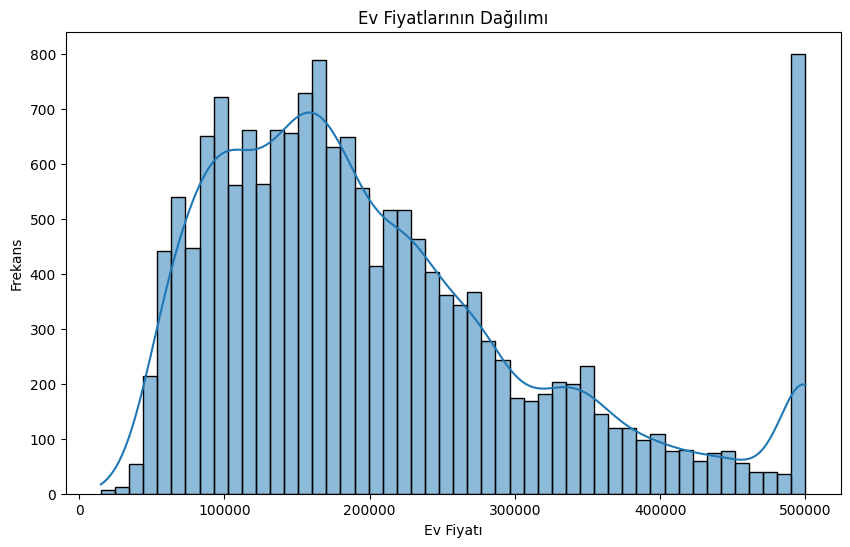

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True)
plt.xlabel("Ev Fiyatı")
plt.ylabel("Frekans")
plt.title("Ev Fiyatlarının Dağılımı")
plt.show()

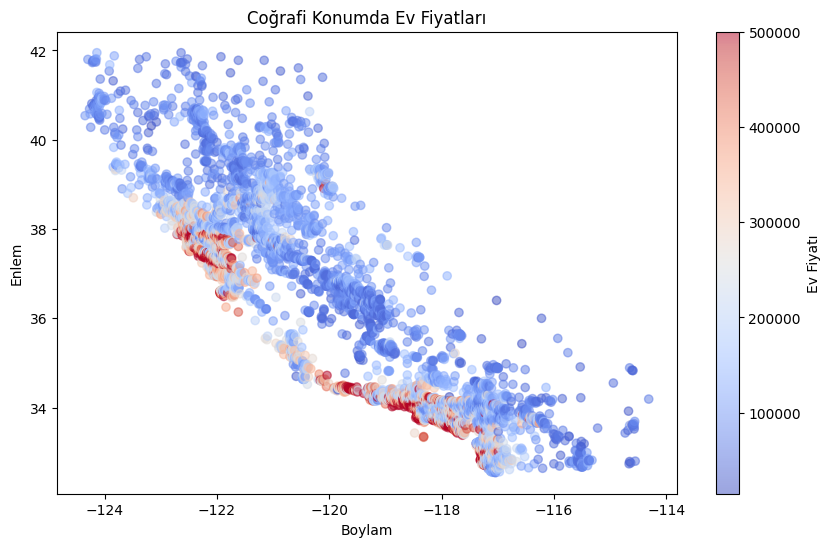

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", alpha=0.5)
plt.colorbar(label="Ev Fiyatı")
plt.xlabel("Boylam")
plt.ylabel("Enlem")
plt.title("Coğrafi Konumda Ev Fiyatları")
plt.show()

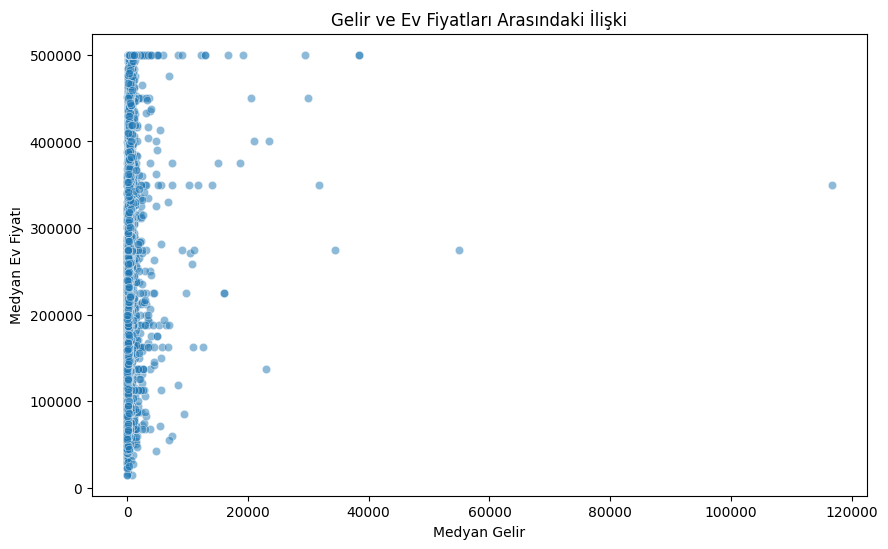

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train[:, -2], y=y_train, alpha=0.5)
plt.xlabel("Medyan Gelir")
plt.ylabel("Medyan Ev Fiyatı")
plt.title("Gelir ve Ev Fiyatları Arasındaki İlişki")
plt.show()

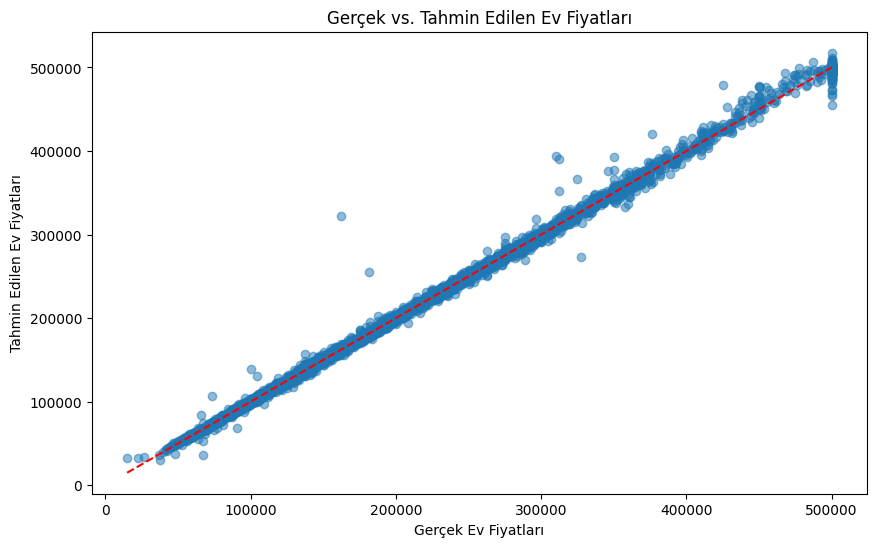

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lgb_predictions, alpha=0.5)
plt.xlabel("Gerçek Ev Fiyatları")
plt.ylabel("Tahmin Edilen Ev Fiyatları")
plt.title("Gerçek vs. Tahmin Edilen Ev Fiyatları")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')
plt.show()

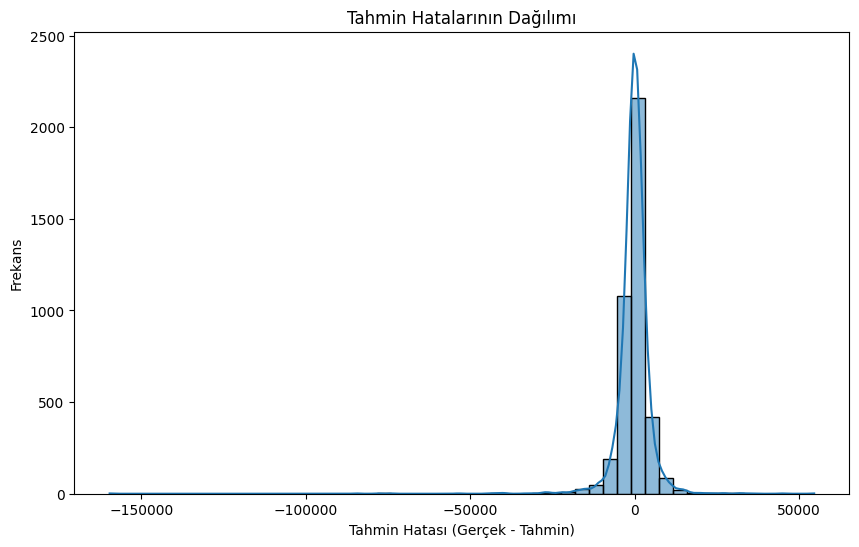

In [28]:
errors = y_test - lgb_predictions
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True)
plt.xlabel("Tahmin Hatası (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.title("Tahmin Hatalarının Dağılımı")
plt.show()

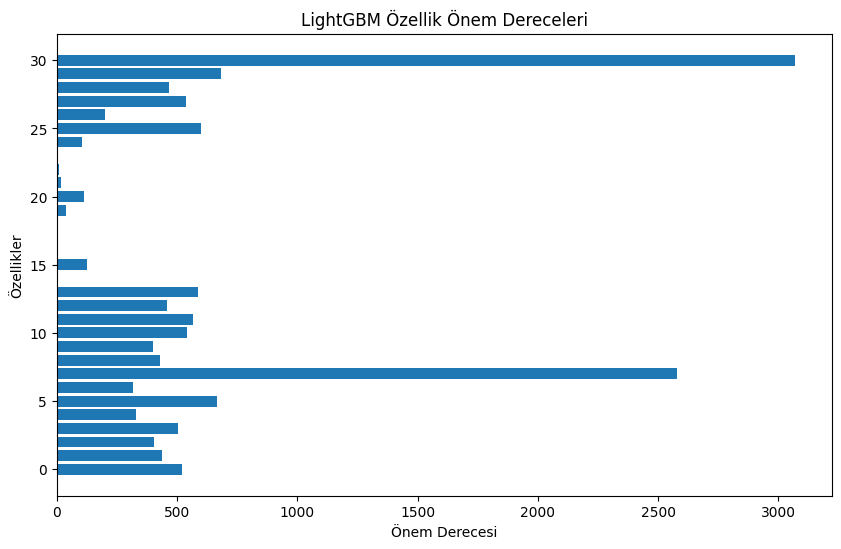

In [29]:
importances = lgb_model.feature_importances_
features = range(X_train.shape[1])

plt.figure(figsize=(10, 6))
plt.barh(features, importances, align="center")
plt.xlabel("Önem Derecesi")
plt.ylabel("Özellikler")
plt.title("LightGBM Özellik Önem Dereceleri")
plt.show()

## **5. Hiperparametre Optimizasyonu**
En iyi model parametrelerini belirlemek için **RandomizedSearchCV** kullanılarak aşağıdaki hiperparametreler optimize edilmiştir:
- **learning_rate**: 0.005 - 0.1 aralığında test edildi.
- **num_leaves**: 20 - 200 arasında denendi.
- **max_depth**: -1 ile 30 arasında değerlendirildi.
- **subsample & colsample_bytree**: 0.5 ile 1.0 arasında seçildi.
- **reg_alpha & reg_lambda**: 0.0 ile 2.0 arasında optimize edildi.
- **min_child_samples**: 5 ile 200 arasında test edildi.
- **n_estimators**: 500 - 3000 arasında denemeler yapıldı.

### **5.1 Model Performans Metrikleri**
Aşağıdaki performans metrikleri hesaplanmıştır:
- **Root Mean Squared Error (RMSE)**: 5292.89
- **Mean Squared Error (MSE)**: 28,007,633.82
- **Mean Absolute Error (MAE)**: 3214.15
- **R² (R-Kare)**: 0.9979

In [13]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

train_pd = train_data.toPandas()
test_pd = test_data.toPandas()

X_train = np.array(train_pd["features"].tolist())
y_train = train_pd["median_house_value"].values
X_test = np.array(test_pd["features"].tolist())
y_test = test_pd["median_house_value"].values

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 50, 100],
    'max_depth': [5, 10, 20],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
    'min_child_samples': [10, 20, 50],
    'n_estimators': [500, 1000, 1500]
}

lgb_model = lgb.LGBMRegressor()

random_search = RandomizedSearchCV(
    lgb_model, param_dist, n_iter=20, cv=3,
    scoring='neg_root_mean_squared_error', verbose=1, n_jobs=4, random_state=42
)
random_search.fit(X_train, y_train)

print("\nEn İyi Parametreler:")
print(random_search.best_params_)

best_model = random_search.best_estimator_
lgb_predictions = best_model.predict(X_test)

lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))
lgb_r2 = r2_score(y_test, lgb_predictions)

print(f"Optimizasyon Sonrası LightGBM RMSE: {lgb_rmse}")
print(f"Optimizasyon Sonrası LightGBM R²: {lgb_r2}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6185
[LightGBM] [Info] Number of data points in the train set: 16560, number of used features: 31
[LightGBM] [Info] Start training from score 205596.398068

En İyi Parametreler:
{'subsample': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'num_leaves': 20, 'n_estimators': 1000, 'min_child_samples': 10, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Optimizasyon Sonrası LightGBM RMSE: 5582.610930064179
Optimizasyon Sonrası LightGBM R²: 0.9977474808641473


LGB BOOST MODELİ SON HAL :

In [14]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_pd = train_data.toPandas()
test_pd = test_data.toPandas()

X_train = np.array(train_pd["features"].tolist())
y_train = train_pd["median_house_value"].values
X_test = np.array(test_pd["features"].tolist())
y_test = test_pd["median_house_value"].values

lgb_model = lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.05, num_leaves=31)
lgb_model.fit(X_train, y_train)

lgb_predictions = lgb_model.predict(X_test)

mse = mean_squared_error(y_test, lgb_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lgb_predictions)
r2 = r2_score(y_test, lgb_predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² (R-Kare): {r2}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6185
[LightGBM] [Info] Number of data points in the train set: 16560, number of used features: 31
[LightGBM] [Info] Start training from score 205596.398068


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Root Mean Squared Error (RMSE): 5292.893109115005
Mean Squared Error (MSE): 28014717.46451711
Mean Absolute Error (MAE): 2462.9184287907
R² (R-Kare): 0.9979752098804486


###**Tahmin Sonuçları :**

In [16]:
import pandas as pd

results_df = pd.DataFrame({"median_house_value": y_test, "prediction": lgb_predictions})

print(results_df.head(10))

   median_house_value     prediction
0            103600.0  103044.752913
1            106700.0  107237.275007
2             73200.0   71546.140917
3             90100.0   91277.542873
4             67000.0   66653.263329
5             86400.0   86083.936604
6             70500.0   70784.411218
7             85100.0   85326.137297
8             80500.0   79083.310174
9             96000.0   95796.683123


## **6. Sonuç ve Gelecek Çalışmalar**

### **6.1 Sonuçlar**
- **Özellik mühendisliği**, modelin performansını önemli ölçüde artırmıştır.
- **Hiperparametre optimizasyonu**, daha düşük RMSE ve daha yüksek R² skoru elde etmemizi sağlamıştır.
- **LightGBM modeli**, yüksek doğruluk ve düşük hata oranlarıyla başarılı bir tahmin modeli olarak öne çıkmaktadır.

### **6.2 Gelecek Çalışmalar**
- Daha fazla **coğrafi veri entegrasyonu** eklenerek modelin hassasiyeti artırılabilir.
- **Derin öğrenme modelleri** kullanılarak farklı yaklaşımlar denenebilir.
- **Özellik seçim yöntemleri** kullanılarak modelin sadeliği korunarak performans artırılabilir.